
            ANDERSON MODEL - POPULATION DYNAMICS            
System parameters: e₁=-5, U=10
Gamma values: [2.0, 5.0, 10.0, 50.0, 100.0]
Time range: 0 to 50.0 (with 1000 points)

>>> Generating individual plots for each gamma...

Solving for γ = 2.0
10.0%. Run time:   0.11s. Est. time left: 00:00:00:01
20.0%. Run time:   0.19s. Est. time left: 00:00:00:00
30.0%. Run time:   0.26s. Est. time left: 00:00:00:00
40.0%. Run time:   0.33s. Est. time left: 00:00:00:00
50.1%. Run time:   0.39s. Est. time left: 00:00:00:00
60.1%. Run time:   0.45s. Est. time left: 00:00:00:00
70.1%. Run time:   0.52s. Est. time left: 00:00:00:00
80.1%. Run time:   0.58s. Est. time left: 00:00:00:00
90.1%. Run time:   0.64s. Est. time left: 00:00:00:00
100.0%. Run time:   0.71s. Est. time left: 00:00:00:00
Total run time:   0.71s
Computation time: 0.81s

Solving for γ = 5.0
10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.20s. Est. time left: 00:00:00:00
30.0%. Run time:   0.27s. Est. t

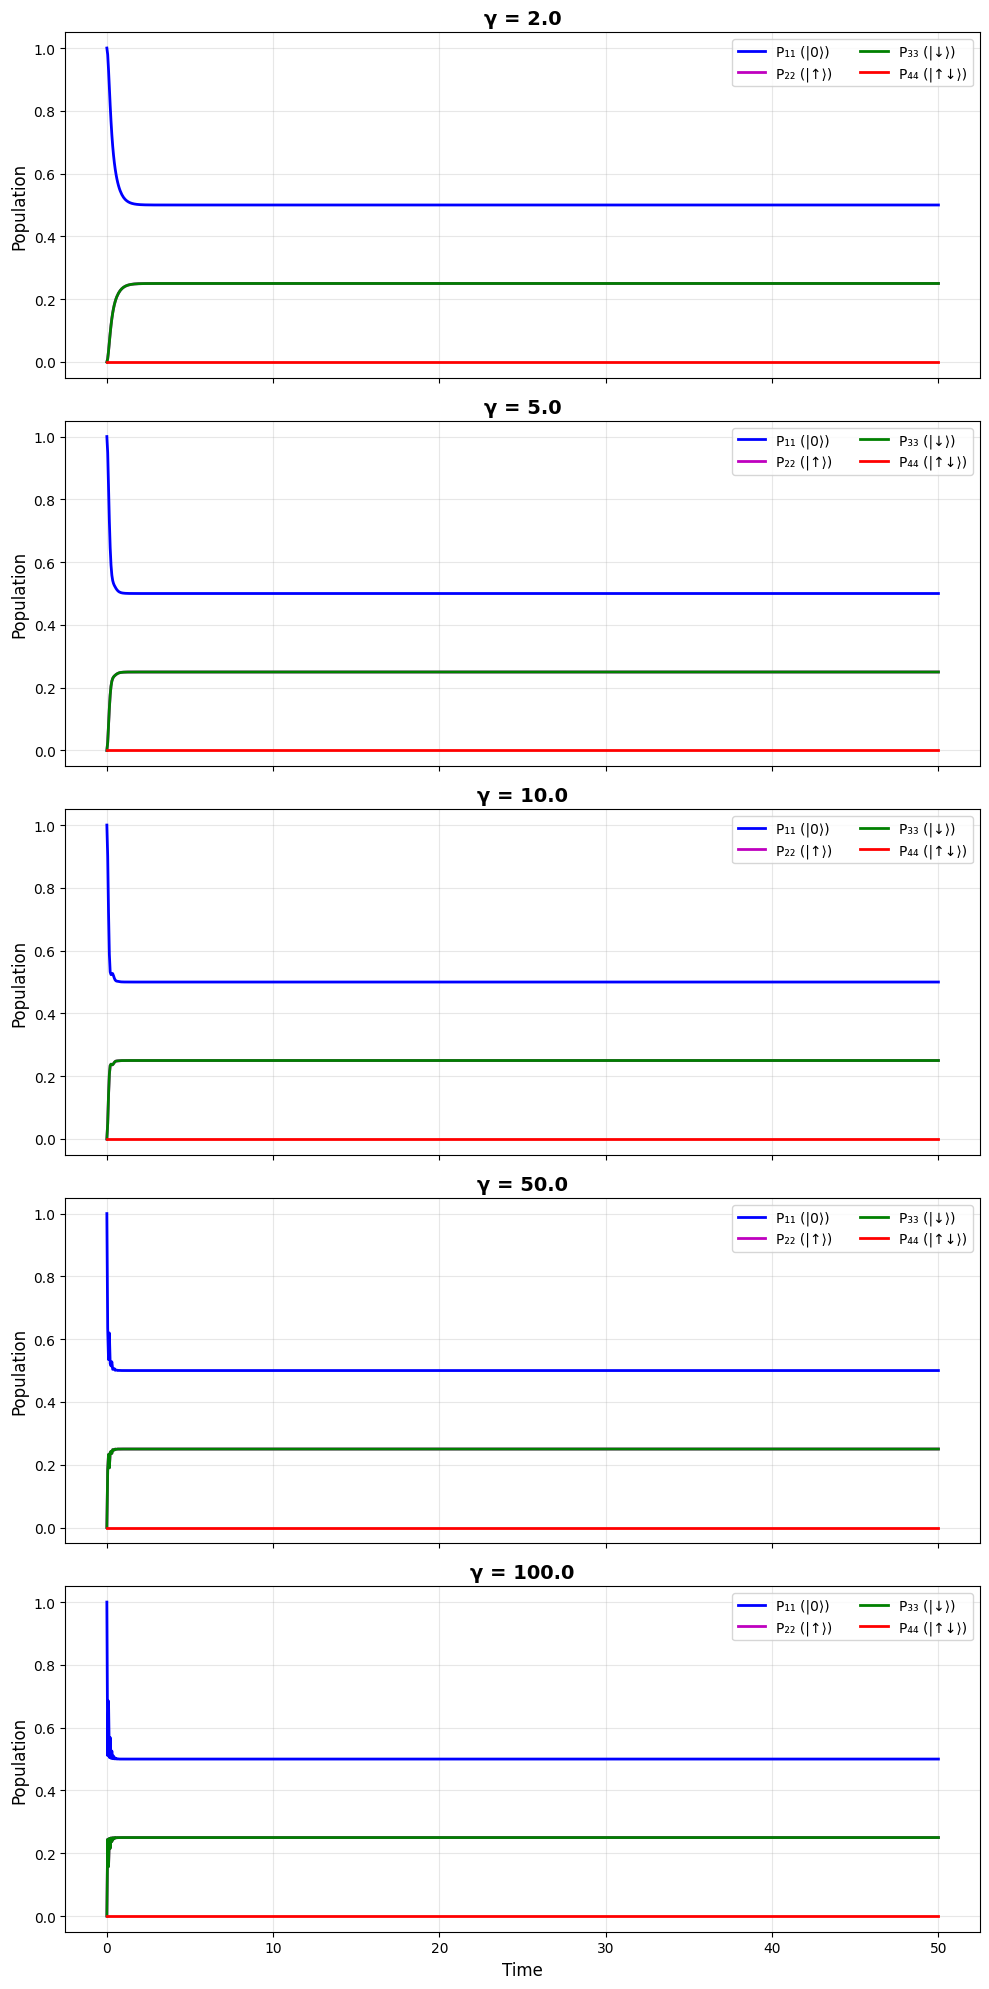


>>> Generating comparison plots...

Solving for γ = 2.0
10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.20s. Est. time left: 00:00:00:00
30.0%. Run time:   0.27s. Est. time left: 00:00:00:00
40.0%. Run time:   0.34s. Est. time left: 00:00:00:00
50.1%. Run time:   0.41s. Est. time left: 00:00:00:00
60.1%. Run time:   0.48s. Est. time left: 00:00:00:00
70.1%. Run time:   0.55s. Est. time left: 00:00:00:00
80.1%. Run time:   0.62s. Est. time left: 00:00:00:00
90.1%. Run time:   0.70s. Est. time left: 00:00:00:00
100.0%. Run time:   0.77s. Est. time left: 00:00:00:00
Total run time:   0.77s
Computation time: 0.88s

Solving for γ = 5.0
10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.28s. Est. time left: 00:00:00:00
40.0%. Run time:   0.34s. Est. time left: 00:00:00:00
50.1%. Run time:   0.42s. Est. time left: 00:00:00:00
60.1%. Run time:   0.50s. Est. time left: 00:00:00:00
70.1%. Ru

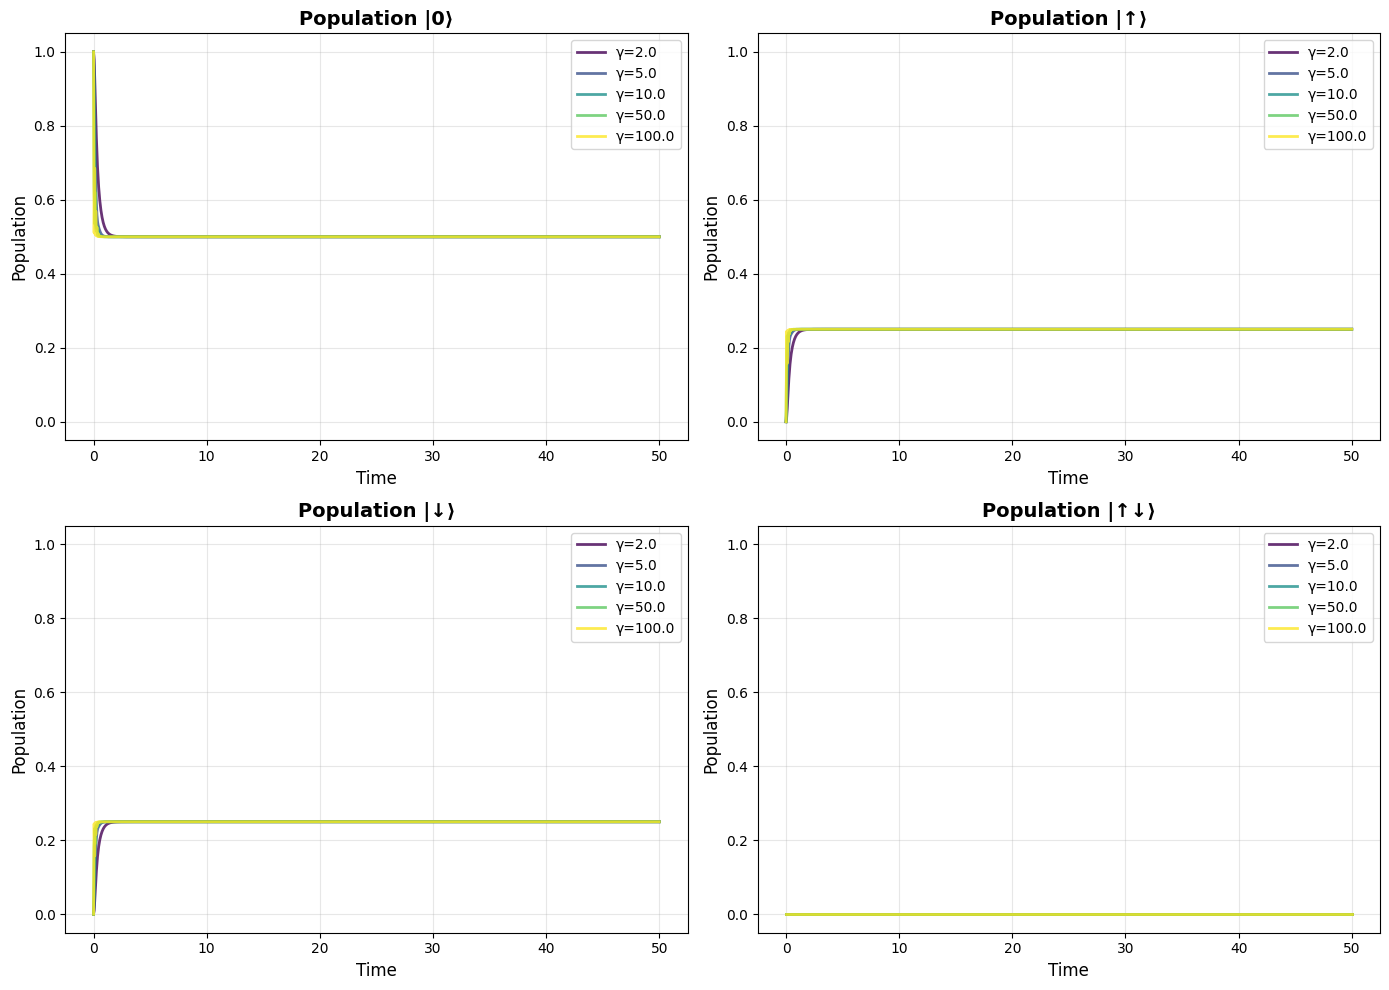


             SIMULATION COMPLETED SUCCESSFULLY              



In [13]:
import contextlib
import dataclasses
import time
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.core.environment import LorentzianEnvironment
from qutip.solver.heom import HEOMSolver

@contextlib.contextmanager
def timer(label):
    """Simple utility for timing functions"""
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start:.2f}s")

@dataclasses.dataclass
class SystemParameters:
    e1: float = -5  
    U: float = 10  
    Nbos: int = 2

    def __post_init__(self):
        d_up = tensor(destroy(2), qeye(self.Nbos))
        sz = sigmaz()
        d_dn = tensor(-sz, destroy(2))
        self.H = (
            self.e1 * (d_up.dag() * d_up + d_dn.dag() * d_dn) +
            self.U * (d_up.dag() * d_up * d_dn.dag() * d_dn)
        )
        self.Q1 = d_up
        self.Q2 = d_dn
        self.Q = d_up + d_dn

@dataclasses.dataclass
class LorentzianBathParameters:
    lead: str
    Q: object
    gamma: float = 0.5
    W: float = 10
    T: float = 25E27
    theta: float = 0

    def __post_init__(self):
        assert self.lead in ("L", "R")
        self.beta = 1 / self.T
        if self.lead == "L":
            self.mu = self.theta / 2.0
        else:
            self.mu = -self.theta / 2.0

def create_density_matrices(Nbos=2):
    """Create the initial density matrices"""
    dims = [[2, Nbos], [2, Nbos]]
    
    rho_0 = np.zeros((4, 4))
    rho_0[0, 0] = 1
    rho_0 = Qobj(rho_0, dims=dims)
    
    rho_1 = np.zeros((4, 4))
    rho_1[1, 1] = 1
    rho_1 = Qobj(rho_1, dims=dims)
    
    rho_2 = np.zeros((4, 4))
    rho_2[2, 2] = 1
    rho_2 = Qobj(rho_2, dims=dims)
    
    rho_3 = np.zeros((4, 4))
    rho_3[3, 3] = 1
    rho_3 = Qobj(rho_3, dims=dims)
    
    return rho_0, rho_1, rho_2, rho_3

def solve_for_gamma(sys_p, gamma_value, tlist, Nk=5):
    """Solve the HEOM for a specific gamma value"""
    
    # Create bath with specific gamma
    bath = LorentzianBathParameters(Q=sys_p.Q, lead="L", gamma=gamma_value)
    
    # Create environment
    env = LorentzianEnvironment(bath.T, bath.mu, bath.gamma, bath.W)
    env_pade = env.approx_by_pade(Nk=Nk)
    
    # Options for solver
    options = {
        "nsteps": 1500,
        "store_states": True,
        "rtol": 1e-12,
        "atol": 1e-12,
        "method": "vern9",
    }
    
    # Create solver
    solver = HEOMSolver(
        sys_p.H,
        (env_pade, bath.Q),
        max_depth=2,
        options=options,
    )
    
    # Initial state
    rho_0, _, _, _ = create_density_matrices(sys_p.Nbos)
    
    # Solve
    result = solver.run(rho_0, tlist)
    
    # Get steady state
    try:
        rho_ss, _ = solver.steady_state()
    except Exception as e:
        print(f"Warning: steady_state failed with {e}, using final state")
        # Utiliser le dernier état de la simulation
        rho_ss = result.states[-1]
    
    return result, rho_ss

def extract_populations(result, rho_list):
    """Extract populations from result object"""
    populations = []
    
    # Vérifier la structure de result
    if hasattr(result, 'states'):
        states = result.states
    elif hasattr(result, 'final_state'):
        # Si on a qu'un état final, créer une liste
        states = [result.final_state]
    else:
        raise AttributeError("Cannot find states in result object")
    
    # Calculer les populations pour chaque observable
    for rho in rho_list:
        pop_timeseries = []
        for state in states:
            # expect retourne un nombre complexe, on prend la partie réelle
            val = expect(rho, state)
            if isinstance(val, complex):
                val = val.real
            pop_timeseries.append(val)
        populations.append(pop_timeseries)
    
    return populations

def plot_populations_for_gammas(sys_p, gamma_values, tlist, save_path="populations_gamma.png"):
    """Plot populations for different gamma values"""
    
    # Create density matrices for expectations
    rho_0, rho_1, rho_2, rho_3 = create_density_matrices(sys_p.Nbos)
    rho_list = [rho_0, rho_1, rho_2, rho_3]
    
    # Create subplots - one for each gamma
    n_gammas = len(gamma_values)
    fig, axes = plt.subplots(n_gammas, 1, figsize=(10, 4*n_gammas), sharex=True)
    
    # Make sure axes is always iterable
    if n_gammas == 1:
        axes = [axes]
    
    colors = ['b', 'm', 'g', 'r']
    labels = ['P₁₁ (|0⟩)', 'P₂₂ (|↑⟩)', 'P₃₃ (|↓⟩)', 'P₄₄ (|↑↓⟩)']
    
    # Solve and plot for each gamma
    for idx, gamma in enumerate(gamma_values):
        print(f"\n{'='*50}")
        print(f"Solving for γ = {gamma}")
        print(f"{'='*50}")
        
        with timer(f"Computation time"):
            result, rho_ss = solve_for_gamma(sys_p, gamma, tlist)
        
        # Extract populations
        populations = extract_populations(result, rho_list)
        
        ax = axes[idx]
        
        # Plot each population
        for i, (pop, color, label) in enumerate(zip(populations, colors, labels)):
            ax.plot(tlist, pop, color=color, linewidth=2, label=label)
            
            # Add steady state line
            pop_ss = expect(rho_list[i], rho_ss)
            if isinstance(pop_ss, complex):
                pop_ss = pop_ss.real
            ax.axhline(pop_ss, color=color, linestyle=':', 
                      linewidth=1.5, alpha=0.6)
        
        ax.set_ylabel('Population', fontsize=12)
        ax.set_title(f'γ = {gamma}', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10, ncol=2)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)
    
    axes[-1].set_xlabel('Time', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Figure saved as: {save_path}")
    plt.show()

def plot_populations_comparison(sys_p, gamma_values, tlist, save_path="populations_comparison.png"):
    """Plot all populations on same graph for comparison"""
    
    rho_0, rho_1, rho_2, rho_3 = create_density_matrices(sys_p.Nbos)
    rho_list = [rho_0, rho_1, rho_2, rho_3]
    labels_base = ['|0⟩', '|↑⟩', '|↓⟩', '|↑↓⟩']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Define colormap for gamma values
    cmap = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    # Store all results
    all_populations = []
    
    for idx, gamma in enumerate(gamma_values):
        print(f"\n{'='*50}")
        print(f"Solving for γ = {gamma}")
        print(f"{'='*50}")
        
        with timer(f"Computation time"):
            result, rho_ss = solve_for_gamma(sys_p, gamma, tlist)
        
        # Extract populations
        populations = extract_populations(result, rho_list)
        all_populations.append(populations)
    
    # Plot each population type in separate subplot
    for i, label in enumerate(labels_base):
        for idx, gamma in enumerate(gamma_values):
            pop = all_populations[idx][i]
            axes[i].plot(tlist, pop, color=cmap[idx], linewidth=2, 
                        label=f'γ={gamma}', alpha=0.8)
        
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('Population', fontsize=12)
        axes[i].set_title(f'Population {label}', fontsize=14, fontweight='bold')
        axes[i].legend(loc='best', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(-0.05, 1.05)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Comparison figure saved as: {save_path}")
    plt.show()

# ============ MAIN EXECUTION ============
if __name__ == "__main__":
    
    # System parameters
    sys_p = SystemParameters()
    
    # Time array
    tlist = np.linspace(0, 50, 1000)
    
    # Gamma values to test
    #gamma_values = [0.0, 0.25, 0.5, 0.75, 1.0]
    gamma_values = [2.0, 5.0, 10.0, 50.0, 100.0]
    
    print("\n" + "="*60)
    print(" ANDERSON MODEL - POPULATION DYNAMICS ".center(60))
    print("="*60)
    print(f"System parameters: e₁={sys_p.e1}, U={sys_p.U}")
    print(f"Gamma values: {gamma_values}")
    print(f"Time range: 0 to {tlist[-1]} (with {len(tlist)} points)")
    print("="*60)
    
    # Plot 1: Separate plots for each gamma
    print("\n>>> Generating individual plots for each gamma...")
    plot_populations_for_gammas(sys_p, gamma_values, tlist)
    
    # Plot 2: Comparison plot (all gammas on same graphs)
    print("\n>>> Generating comparison plots...")
    plot_populations_comparison(sys_p, gamma_values, tlist)
    
    print("\n" + "="*60)
    print(" SIMULATION COMPLETED SUCCESSFULLY ".center(60))
    print("="*60 + "\n")